# Artificial Intelligence
## Computer Vision / Convolutional Neural Networks (CNN)
### Harmful Species Identification (Spotted Lantern Fly vs. Asian Longhorn Beetle)

### What is a convolutional neural network (CNN)?

A convolutional neural network (CNN) is a category of machine learning model, namely a type of deep learning algorithm well suited to analyzing visual data. CNNs -- sometimes referred to as convnets -- use principles from linear algebra, particularly convolution operations, to extract features and identify patterns within images. Although CNNs are predominantly used to process images, they can also be adapted to work with audio and other signal data.

CNN architecture is inspired by the connectivity patterns of the human brain -- in particular, the visual cortex, which plays an essential role in perceiving and processing visual stimuli. The artificial neurons in a CNN are arranged to efficiently interpret visual information, enabling these models to process entire images. Because CNNs are so effective at identifying objects, they are frequently used for computer vision tasks such as image recognition and object detection, with common use cases including self-driving cars, facial recognition and medical image analysis.

Unlike CNNs, older forms of neural networks often needed to process visual data in a piecemeal manner, using segmented or lower-resolution input images. A CNN's comprehensive approach to image recognition lets it outperform a traditional neural network on a range of image-related tasks and, to a lesser extent, speech and audio processing.

### How do convolutional neural networks work?
CNNs use a series of layers, each of which detects different features of an input image. Depending on the complexity of its intended purpose, a CNN can contain dozens, hundreds or even thousands of layers, each building on the outputs of previous layers to recognize detailed patterns.


Reference:
+ https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats
+ https://pythonawesome.com/an-animated-and-smart-progress-bar-for-python/
+ https://www.tensorflow.org/tutorials/images/cnn
+ https://www.geeksforgeeks.org/computer-vision/
+ https://www.machinelearningnuggets.com/cnn-tensorflow/
+ https://www.datacamp.com/tutorial/cnn-tensorflow-python
+ https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
+ https://www.baeldung.com/cs/ml-loss-accuracy
+ https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew
+https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

In [2]:
BUCKET_NAME     = "cio-training-vertex-colab"
PROJECT_ID      = "ai-training-2024-08-09"
LOCATION        = "us-central1"
secret_name     = "ai-training-key-secret"
secret_version  = "latest"
project_id      = "usfs-tf-admin"
resource_name   = f"projects/{project_id}/secrets/{secret_name}/versions/{secret_version}"

## Environment Check

In [3]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    print("You are running this notebook in Google Colab.")
else:
    print("You are running this notebook with Jupyter iPython runtime.")

You are running this notebook in Google Colab.


# Library Management

In [4]:
import sys
import subprocess
import importlib.util

In [5]:
libraries=["keras", "imageio", "seaborn", "alive-progress", "numpy", "Pillow", "numba", "tensorrt"]
#"tf-keras",

for library in libraries:
    if library == "Pillow":
      spec = importlib.util.find_spec("PIL")
    else:
      spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"])
    else:
      print("Library " + library + " already installed.")

Library keras already installed.
Library imageio already installed.
Library seaborn already installed.
Installing library alive-progress
Library numpy already installed.
Library Pillow already installed.
Library numba already installed.
Installing library tensorrt


## Libraries

In [6]:
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# a set of libraries that perhaps should always be in Python source
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import socket
import json
import pickle
from pathlib import Path
import itertools
import datetime
import re
import shutil
import string
import io
import os
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import textwrap
import random
import glob
import os
import PIL
import time
import subprocess


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Additional libraries for this work
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import math
from base64 import b64decode
from IPython.display import Image
from IPython.display import clear_output
import requests
from random import random
from random import randint
from random import seed
from collections import Counter

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Graphics
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import PIL.ImageOps
from imageio import imread
import seaborn as sns

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Data Science Libraries
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import numpy as np
import pandas as pd

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Tensorflow and related AI libraries
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow import keras
import tensorrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

#existing trained model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# progress bar
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from alive_progress import alive_bar
#from alive_progress.styles import showtime, Show
from tqdm.notebook import trange, tqdm

#################################
# - Setup some basic timers material
#################################
from time import perf_counter

warnings.filterwarnings('ignore')               # don't print out warnings

## Variables

In [7]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "MLCNN"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS & APP VARIABLES
############################################
BATCH_SIZE = 32
TRAIN_DATA_DIR="./folderOnColab/ENTOMOLOGY/train"
VALIDATION_DATA_DIR="./folderOnColab/ENTOMOLOGY/validation"
VALIDATION_SPLIT=0.2
IMG_HEIGHT=224
IMG_WIDTH=224
EPOCHS=50
BOLD_START = "\033[1m"
BOLD_END = "\033[0;0m"

METRICS = metrics=['accuracy',
                  	tf.keras.metrics.Precision(name='precision'),
                  	tf.keras.metrics.Recall(name='recall')]

#You can also adjust the verbosity by changing the value of TF_CPP_MIN_LOG_LEVEL:
#
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed
TF_CPP_MIN_LOG_LEVEL_SETTING=0

TEXT_WIDTH=77

############################################
# APPLICATION VARIABLES
############################################
categories=["ASIAN_LONGHORN_BEETLE", "SPOTTED_LANTERN_FLY"]
categories_short_name=["alb", "slf"]
range_max=5
plot_max=330
start = "\033[1m"
end = "\033[0;0m"
THE_DEVICE_NAME="/job:localhost/replica:0/task:0/device:GPU:0"
############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING

############################################
# Set the Seed for the experiment (ask me why?)
############################################
# seed the pseudorandom number generator
# THIS IS ESSENTIAL FOR CONSISTENT MODEL OUTPUT, remember these are random in nature.
SEED_INIT=7

seed(SEED_INIT)

tf.random.set_seed(SEED_INIT)

np.random.seed(SEED_INIT)

## Function

In [8]:
## Outputs library version history of effort.
#
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=40
    package_version_length=20

    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas", "keras", "seaborn"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             print(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        print(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        print(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        print(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        print(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        print(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        print(f"{'     count':<40}#: {torch.cuda.device_count()}")
        print(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass


    try:
      print(f"{'OpenAI Azure Version':<40}#: {str(the_openai_version):<20}")
    except Exception as e:
      pass
    return

## Function Call

In [9]:
lib_diagnostics()
wrapper = textwrap.TextWrapper(width=TEXT_WIDTH)

keras                                   #: 3.4.1               
nltk                                    #: 3.8.1               
numpy                                   #: 1.26.4              
pandas                                  #: 2.1.4               
seaborn                                 #: 0.13.1              
TensorFlow version                      #: 2.17.0              
     gpu.count:                         #: 1
     cpu.count:                         #: 1


## Check your resources from a CPU/GPU perspective

In [16]:
print(f"{BOLD_START}List Devices{BOLD_END} #########################################")
try:
  from tensorflow.python.client import device_lib
  print(device_lib.list_local_devices())
  print("")
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  print(str(repr(e)))

print(f"{BOLD_START}Devices Counts{BOLD_END} ########################################")
try:
  print(f"Num GPUs Available: {str(len(tf.config.experimental.list_physical_devices('GPU')))}" )
  print(f"Num CPUs Available: {str(len(tf.config.experimental.list_physical_devices('CPU')))}" )
  print("")
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  print(str(repr(e)))

print(f"{BOLD_START}Optional Enablement{BOLD_END} ####################################")
try:
  gpus = tf.config.experimental.list_physical_devices('GPU')
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  print(str(repr(e)))

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print( str( str(len(gpus)) + " Physical GPUs," + str(len(logical_gpus)) + " Logical GPU") )
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(str(repr(e)))
  print("")

List Devices #########################################
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4792682496170037034
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14433386496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6886356848089878117
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]

Devices Counts ########################################
Num GPUs Available: 1
Num CPUs Available: 1

Optional Enablement ####################################
1 Physical GPUs,1 Logical GPU



## Release memory from current GPU's

In [11]:
"""
from numba import cuda

try:
    device = cuda.get_current_device()
    device.reset()
except Exception as e:
    print(str(repr(e)))
"""

'\nfrom numba import cuda\n\ntry:\n    device = cuda.get_current_device()\n    device.reset()\nexcept Exception as e:\n    print(str(repr(e)))\n'

In [12]:
"""
%load_ext tensorboard
"""

'\n%load_ext tensorboard\n'

## Input Sources
### Copy a repository of images to the local Google Colab instance


In [13]:
target_folder="./folderOnColab"

In [14]:

#!rm -rf ./folderOnColab && echo "Ok, removed." || { echo "No folder to remove."; exit 1; }

#BEARS
#!mkdir -p ./folderOnColab && echo "Folder created." || { echo "Failed to create folder, perhaps it already exists.";   }
#!gsutil -m cp -r gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/bear ./folderOnColab

#ENTOMOLOGY
#!mkdir -p ./folderOnColab && echo "Folder created." || { echo "Failed to create folder, perhaps it already exists.";   }
#!gsutil -m cp -r gs://usfs-gcp-rand-test-data-usc1/public_source/computervision/ENTOMOLOGY ./folderOnColab

print(f"Creating a folder ({target_folder}) to store project data.")
subprocess.run(["mkdir", "-p" , target_folder], check=True)

print(f"Copying file to target folder: {target_folder}")
subprocess.run(["gsutil", "-m" , "cp", "-r", f"gs://{BUCKET_NAME}/training-data/computervision/ENTOMOLOGY",  target_folder], check=True)


Creating a folder (./folderOnColab) to store project data.
Copying file to target folder: ./folderOnColab


CompletedProcess(args=['gsutil', '-m', 'cp', '-r', 'gs://cio-training-vertex-colab/training-data/computervision/ENTOMOLOGY', './folderOnColab'], returncode=0)

### List the files copied, are they there?

In [17]:
print(f"Display of files in target folder: {target_folder}")
!ls -hF ./folderOnColab/ENTOMOLOGY | head -40

Display of files in target folder: ./folderOnColab
batch_gcp_imageManifest.sh
entomology.csv
image_aug.py
rename_ai_images.sh
train/
validation/


### Show some pictures

Let's look at the first set of images in the dataset.

What happens if you change "range_max" to another number, like 12?

ALB
|▉▉▉▉▉▉▉▉⚠︎                               | (!) 1/5 [20%] in 0.1s (81.66/s)      
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎                       | (!) 2/5 [40%] in 0.1s (88.89/s)      
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎               | (!) 3/5 [60%] in 0.0s (6920.33/s)    
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎       | (!) 4/5 [80%] in 0.0s (9867.25/s)    
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 5/5 [100%] in 0.0s (13901.93/s)      


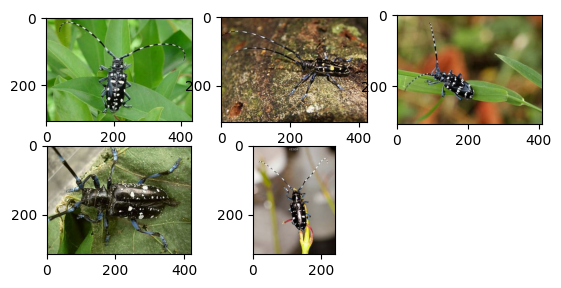

SLF
|▉▉▉▉▉▉▉▉⚠︎                               | (!) 1/5 [20%] in 0.1s (60.09/s)      
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎                       | (!) 2/5 [40%] in 0.0s (4585.19/s)    
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎               | (!) 3/5 [60%] in 0.0s (8753.36/s)    
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉⚠︎       | (!) 4/5 [80%] in 0.0s (10705.14/s)   
|▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 5/5 [100%] in 0.0s (16794.65/s)      


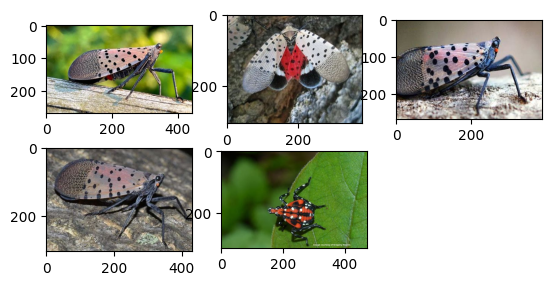

In [18]:
###########################################
#- Show pictures of the image dataset
###########################################

for idx, category in enumerate(categories_short_name):
  print(f"{start}{category.upper()}{end}")
  # define location of dataset
  folder = TRAIN_DATA_DIR + os.sep + category

  # plot first few images
  for i in range(range_max):
    idx=i+1
    with alive_bar(range_max,bar="blocks", spinner="fish2", force_tty=True) as bar:
      bar(idx)
      plt.subplot(plot_max + 1 + i)
      filename = folder + os.sep + f'00{idx}.jpg'
      image = imread(filename)
      plt.imshow(image)
  plt.show()


## OS Configuration Options

In [19]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = str(TF_CPP_MIN_LOG_LEVEL_SETTING)

#To disable GPU access to the current runtime enable -1 for "no GPUs"
#confirmed to work on the Command Line Interface (CLI) of all systems but this one...
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Activation Functions

An activation function is applied on the last fully connected layer depending on the number of categories in the images. The sigmoid activation function is used in a binary problem, while the softmax activation function is applied in a multiclass task.    

## Compiling the model
To compile the neural network the gradient descent is applied. This is the optimization strategy that reduces the errors as the network is learning. There are various optimization strategies but sgd and adam are common approachs. In the compile stage, we also define the loss function and the metrics. We use sparse categorical cross-entropy because the labels are integers. The categorical cross-entropy is used when the labels are one-hot encoded.

## Hyperparameters

Machine learning algorithms have hyperparameters that can be configured to tailor the algorithm to a specific dataset.

Although the dynamics of many hyperparameters are known, the specific effect they will have on the performance of the resulting model on a given dataset is not known. As such, it is a standard practice to test a suite of values for key algorithm hyperparameters for a chosen machine learning algorithm.

This is called hyperparameter tuning or hyperparameter optimization.

It is common to use a naive optimization algorithm for this purpose, such as a random search algorithm or a grid search algorithm.

Hyperparameter Tuning: Function inputs are algorithm hyperparameters, optimization problems that require an iterative global search algorithm.
For more on this topic, see the tutorial:

Hyperparameter Optimization With Random Search and Grid Search
Nevertheless, it is becoming increasingly common to use an iterative global search algorithm for this optimization problem. A popular choice is a Bayesian optimization algorithm that is capable of simultaneously approximating the target function that is being optimized (using a surrogate function) while optimizing it.

This is desirable as evaluating a single combination of model hyperparameters is expensive, requiring fitting the model on the entire training dataset one or many times, depending on the choice of model evaluation procedure (e.g. repeated k-fold cross-validation).

## Optimization Algorithms

Optimization algorithms are the backbone of machine learning models as they enable the modeling process to learn from a given data set. These algorithms are used in order to find the minimum or maximum of an objective function which in machine learning context stands for error or loss.

## Over/Under-fitting

**Overfitting**

In machine learning, overfitting is when a model is too closely trained to a specific set of data, causing it to perform poorly on new data. This can happen when:
+ The model trains for too long on the training data
+ The model is too complex
+ The model memorizes irrelevant information in the training data

An overfitted model is similar to an invention that works well in a lab but not in the real world. It can't make accurate predictions or conclusions from any data other than the training data.

**Underfitting**

Underfitting in machine learning occurs when a model is unable to accurately capture the relationship between input and output data. This can lead to poor model performance and unreliable predictions.

Here are some characteristics of underfitting:
+ High bias
  + Underfit models produce inaccurate results for both the training data and test set.
+ Low variance
  + Underfitting is characterized by low variance.
+ Too simple model
  + Underfitting can occur when a model is too simple, such as a linear regression model trained on a dataset with a polynomial relationship.
+ Not enough training data
  + Underfitting can occur if the model hasn't been trained for long enough or on enough data points.

## References:
+ https://machinelearningmastery.com/why-optimization-is-important-in-machine-learning/
+ https://towardsdatascience.com/understanding-optimization-algorithms-in-machine-learning-edfdb4df766b
+ https://geeksforgeeks.org/optimization-algorithms-in-machine-learning/

## Develop a Baseline CNN Model

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A good starting point is the general architectural principles of the VGG models.

In [20]:
# define cnn model with a single layer
def define_model_1Block():

		model = Sequential()
		model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
		model.add(MaxPooling2D((2, 2)))
		model.add(Flatten())
		model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
		model.add(Dense(2, activation='softmax'))

		# compile model
		opt = SGD(learning_rate=0.001, momentum=0.9)
    #model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
		model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=METRICS)
		model.summary()

		return model

start_t=perf_counter()

try:
  with tf.device(THE_DEVICE_NAME):
    model1 = define_model_1Block()
except RuntimeError as e:
  print(str(repr(e)))

end_t=perf_counter()
print(f"Model setup time: {end_t - start_t}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,381,506 (196.00 MB)

 Trainable params: 51,381,506 (196.00 MB)

 Non-trainable params: 0 (0.00 B)

Model setup time: 0.13994482599991898


In [21]:
# define cnn model with two layers
def define_model_2Block():
		model = Sequential()
		model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
		model.add(MaxPooling2D((2, 2)))
		model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', ))
		model.add(MaxPooling2D((2, 2)))
		model.add(Flatten())
		model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
		model.add(Dense(2, activation='softmax'))
		# compile model
		opt = SGD(learning_rate=0.001, momentum=0.9)
		#model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)
		model.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)
		model.summary()
		return model

start_t=perf_counter()

try:
  with tf.device(THE_DEVICE_NAME):
    model2 = define_model_2Block()
except RuntimeError as e:
  print(str(repr(e)))

end_t=perf_counter()
print(f"Model setup time: {end_t - start_t}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,650 (91.20 MB)

 Trainable params: 23,907,650 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

Model setup time: 0.09362787700001718


In [22]:
# define cnn model with 3 layers
# Adding dropout regularization is a computationally cheap way to regularize a deep neural network.
# Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables
# in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks
# with very different network structures and, in turn, making nodes in the network generally more robust to the inputs.
# https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

def define_model_3Block():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.24))
  model.add(Dense(2,activation='softmax'))

  # compile model
  model.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

  model.summary()
  return model

start_t=perf_counter()

try:
  with tf.device(THE_DEVICE_NAME):
    model3 = define_model_3Block()
except RuntimeError as e:
  print(str(repr(e)))

end_t=perf_counter()
print(f"Model setup time: {end_t - start_t}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       2,768,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,797,730 (10.67 MB)

 Trainable params: 2,797,730 (10.67 MB)

 Non-trainable params: 0 (0.00 B)

Model setup time: 0.13531228800002282


In [23]:
#define a new model using VGG16 with Transfer Learning
def define_model_TransferLearning():
  #transfer learning (VGG16)
  model = VGG16(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  # mark loaded layers as un-trainable, keep the original weights
  for layer in model.layers:
      layer.trainable = False

  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)

  #this layer defines the classification, outputs much match total labels
  output = Dense(2, activation='softmax')(class1)

  # define new model
  model = Model(inputs=model.inputs, outputs=output)

  # optimization
  opt = SGD(learning_rate=0.001, momentum=0.9)

  # compile model
  #model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)
  model.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

  model.summary()
  return model


start_t=perf_counter()

try:
  with tf.device('/job:localhost/replica:0/task:0/device:GPU:0'):
    modelTransfer = define_model_TransferLearning()
except RuntimeError as e:
  print(str(repr(e)))

end_t=perf_counter()
print(f"Transfer learning model setup time: {end_t - start_t}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,338 (68.38 MB)

 Trainable params: 3,211,650 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Transfer learning model setup time: 0.7605904930001088


## Data Marshalling and Augmentation

Reference: https://keras.io/examples/vision/image_classification_from_scratch/

Note that embedding the image augmentation within the model build/fit also allows the image manipulations (only available during training, not permanently stored to disk) to benefit from GPU as well.

In [24]:
print(f"{start}Preparing Training Datasets{end}")
print('\n')

try:
  with tf.device(THE_DEVICE_NAME):

      """
      #deprecated, use tf.data methods to replace this functionality, see: https://www.tensorflow.org/tutorials/load_data/images
      train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
      #data augmentation is a way to improve results, uncomment this line, replacing train_datagen and re-run your experiment
      train_datagen = ImageDataGenerator(width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        rotation_range=45,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        validation_split = .2)
      """

      #see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
      train_it = keras.utils.image_dataset_from_directory(
          directory=TRAIN_DATA_DIR,
          labels="inferred",
          image_size=(IMG_HEIGHT, IMG_WIDTH),
          batch_size=BATCH_SIZE,
          #class_mode='binary',
          label_mode='categorical',
          verbose=True,
          #pad_to_aspect_ratio=False,
          #crop_to_aspect_ratio=False,
          #seed=SEED_INIT,
          #shuffle=True,
          #validation_split=VALIDATION_SPLIT,
          #subset="training",
          )

      #deprecated
      #test_it = train_datagen.flow_from_directory(
      test_it = keras.utils.image_dataset_from_directory(
          directory=VALIDATION_DATA_DIR, # same directory as training data
          labels="inferred",
          image_size=(IMG_HEIGHT, IMG_WIDTH),
          batch_size=BATCH_SIZE,
          #class_mode='binary',
          label_mode='categorical',
          verbose=True,
          #pad_to_aspect_ratio=False,
          #crop_to_aspect_ratio=False,
          #seed=SEED_INIT,
          #shuffle=True,
          #validation_split=VALIDATION_SPLIT,
          #subset="validation",
          )
      #batch size is a hyper-parameter and has influence over training as well.  Larger batch sizes get done faster but take more memory, smaller batch sizes take longer but consume less memory.

except (Exception, RuntimeError) as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)

print("")
class_names = test_it.class_names
print(f"{BOLD_START} Class Names (labels){BOLD_END} ##################################")
print(class_names)
print("")

# it's a good practice to artificially introduce sample diversity by applying
#random yet realistic transformations to the training images, such as random horizontal
#flipping or small random rotations. This helps expose the model to different aspects of
#the training data while slowing down overfitting.
# Apply `data_augmentation` to the training images, see: https://www.tensorflow.org/tutorials/images/data_augmentation
# Note that this is a CPU intensive operation, see the reference above if you
# want to add this transformation to the GPU instead.

print("Augmenting data...")
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.1, seed=SEED_INIT,),
    layers.RandomCrop(IMG_HEIGHT, IMG_WIDTH, seed=SEED_INIT,),
    layers.RandomZoom(0.1,seed=SEED_INIT,)


]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


train_it = train_it.map(
                        lambda img, label: (data_augmentation(img), label),
                        num_parallel_calls=tf_data.AUTOTUNE,
)

#prepare the dataset for maximum performance
AUTOTUNE = tf.data.AUTOTUNE

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_it= train_it.prefetch(tf_data.AUTOTUNE)
test_it = test_it.prefetch(tf_data.AUTOTUNE)

end_t=perf_counter()
print(f"Data read setup time: {end_t - start_t}")



Preparing Training Datasets


Found 1947 files belonging to 2 classes.
Found 103 files belonging to 2 classes.

 Class Names (labels) ##################################
['alb', 'slf']

Augmenting data...
Data read setup time: 3.2456328840003152


## EPOCHS

In machine learning, an epoch is a complete pass of a training dataset through a learning algorithm. It's a fundamental concept that's important because it directly affects how well a model learns and generalizes to new data.

**Number of epochs**
The number of epochs is a hyperparameter that defines how many times the algorithm will work through the entire dataset. The number of epochs can range from 10 to thousands.

## Batch-Size

The choice of batch size can have a significant impact on the learning process. A smaller batch size can lead to faster convergence and can help the model escape from local minima. However, it also introduces more noise into the gradient estimate, which can lead to instability in the learning process.

A larger batch size, on the other hand, can provide a more stable learning process and a more accurate gradient estimate. However, it also requires more computational resources and may lead to slower convergence. Furthermore, it may increase the risk of the model getting stuck in local minima.

## Create a Custom Class for Visualization during Model Training

In [25]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        print("EPOCH start")
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        print("EPOCH end")
        # Storing metrics
        print(logs)
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        #plot metrics, if accuracy show percent else show sliding scale
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric,
                        )
            if metric=="accuracy":
              #current_ax = plt.gca()
              #current_ax.set_ylim([0.0, 1.0])
              #current_ax.set_ylabel("Percent (0.0 - 1.0)")
              axs[i].set_ylim([0.0, 1.0])
              axs[i].set_ylabel("Percent (0.0 - 1.0)")


            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)
                if metric=="val_" + metric:
                  current_ax = plt.gca()
                  axs[i].set_ylim([0.0, 1.0])
                  axs[i].set_ylabel("Percent (0.0 - 1.0)")

            axs[i].legend()
            axs[i].grid()
            #current_ax = plt.gca()
            #axs[i].set_ylim([0.0, 1.0])
            #axs[i].set_ylabel("Percent (0.0 - 1.0)")

        plt.tight_layout()
        plt.show()

## What is Loss and Accruacy?

The lower the loss, the better a model (unless the model has over-fitted to the training data). The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets.

In the case of neural networks, the loss is usually negative log-likelihood and residual sum of squares for classification and regression respectively. Then naturally, the main objective in a learning model is to reduce (minimize) the loss function's value with respect to the model's parameters by changing the weight vector values through different optimization methods, such as backpropagation in neural networks.

Loss value implies how well or poorly a certain model behaves after each iteration of optimization. Ideally, one would expect the reduction of loss after each, or several, iteration(s).

The accuracy of a model is usually determined after the model parameters are learned and fixed and no learning is taking place. Then the test samples are fed to the model and the number of mistakes (zero-one loss) the model makes are recorded, after comparison to the true targets. Then the percentage of misclassification is calculated.

For example, if the number of test samples is 1000 and model classifies 952 of those correctly, then the model's accuracy is 95.2%.

Precision and recall are metrics used in machine learning to evaluate how well a model performs at identifying positive class samples:

+ **Precision**: The proportion of positive class predictions that are correct.
+ **Recall**: The proportion of actual positive class samples that are identified by the model.

Precision and recall are useful for identifying knowledge gaps in a model, especially when the dataset is imbalanced. However, there is a trade-off between the two metrics, so increasing one will usually decrease the other. For example, if a model has 100% recall, but only 50% precision, then it means that the model correctly identified all positive samples, but also incorrectly classified some other observations as positive.
When choosing between precision and recall, it's important to consider the class balance and the cost of different errors. A common metric that combines both precision and recall is the F-score, which is the harmonic average of the two.

### Define an Early Stopper to prevent Overfitting

In [26]:
#specify a call back

#simple callback to show results real-time
#callbacks_list = [PlotLearning()]

#Watch the learning after execution
#call this on the CLI after execution: tensorboard --logdir=./folderOnColab/logs
tensorboard_callback = TensorBoard(log_dir="./folderOnColab/logs")

#another way to increase performance is to stop early, try commenting out the previous callback list
#and uncommenting this one.  See the EPOCHS go from full execution to a shortened cycle.
es_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

#how to you persist your model, how to you deal with overfitting?
mc_callback = ModelCheckpoint('best_model1.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


## Train 1 Block Model

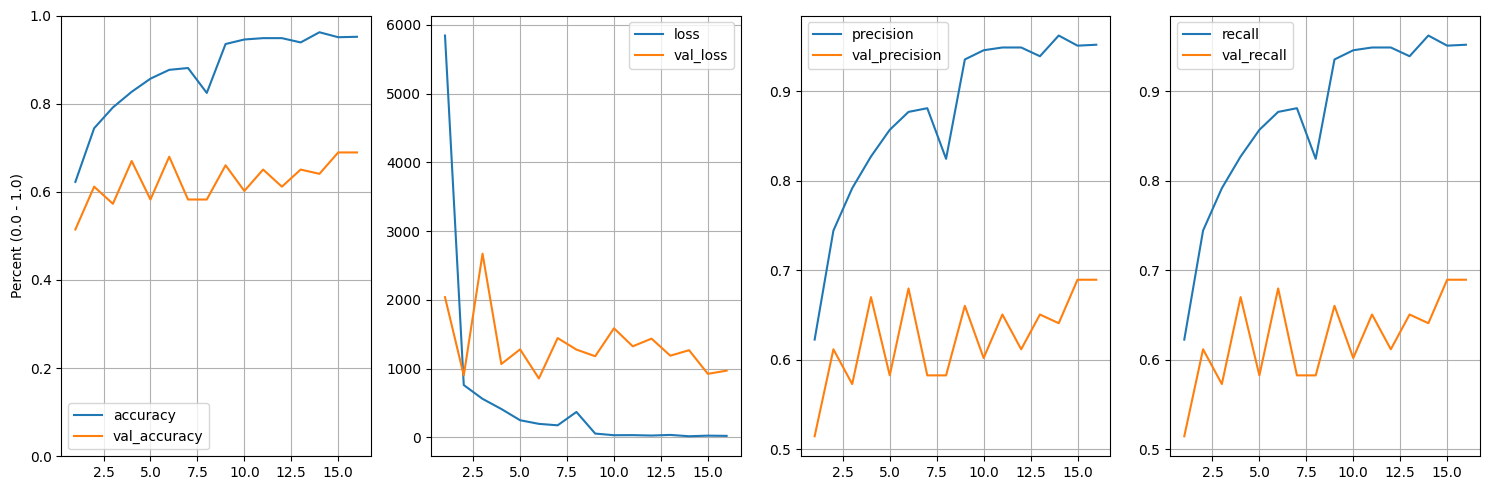


Epoch 16: val_accuracy did not improve from 0.68932
61/61 - 11s - 185ms/step - accuracy: 0.9517 - loss: 21.9479 - precision: 0.9517 - recall: 0.9517 - val_accuracy: 0.6893 - val_loss: 970.3878 - val_precision: 0.6893 - val_recall: 0.6893
Epoch 16: early stopping
Model fit time: 237.65679547199989


In [27]:
# configure callbacks (performed per epoch) for this particular model
callbacks_list = [PlotLearning(), es_callback, mc_callback, tensorboard_callback]

try:
  with tf.device(THE_DEVICE_NAME):
    # fit model, actual training against data, see: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
    history1 = model1.fit(train_it,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_data=test_it,
                          validation_split=VALIDATION_SPLIT,
                          class_weight=None,             #you would be a set of weights per category if you had an unbalanced classification problem
                          verbose=2,                     #0 silent, 1 more, 2 max
                          )

except (Exception, RuntimeError) as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)


end_t=perf_counter()
print(f"Model fit time: {end_t - start_t}")

## Train Model 2 Block (2 layers)

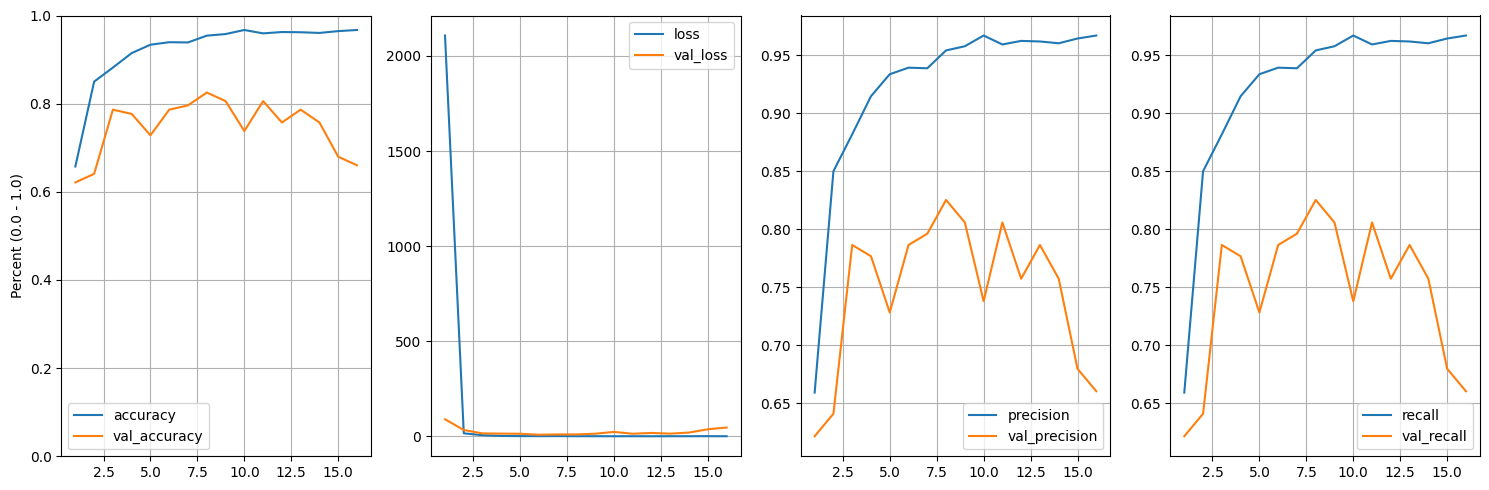


Epoch 16: val_accuracy did not improve from 0.82524
61/61 - 12s - 190ms/step - accuracy: 0.9671 - loss: 0.4202 - precision: 0.9671 - recall: 0.9671 - val_accuracy: 0.6602 - val_loss: 46.2946 - val_precision: 0.6602 - val_recall: 0.6602
Epoch 16: early stopping
Model fit time: 452.7959019160003


In [28]:
mc_callback = ModelCheckpoint('best_model2.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [PlotLearning(), es_callback, mc_callback, tensorboard_callback]

try:
  with tf.device(THE_DEVICE_NAME):
    # fit model, actual training against data, see: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
    history2 = model2.fit(train_it,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_data=test_it,
                          validation_split=VALIDATION_SPLIT,
                          class_weight=None,             #you would be a set of weights per category if you had an unbalanced classification problem
                          verbose=2,                     #0 silent, 1 more, 2 max
                          )

except (Exception, RuntimeError) as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)


end_t=perf_counter()
print(f"Model fit time: {end_t - start_t}")

## Train Model 3 Block (3 layers)

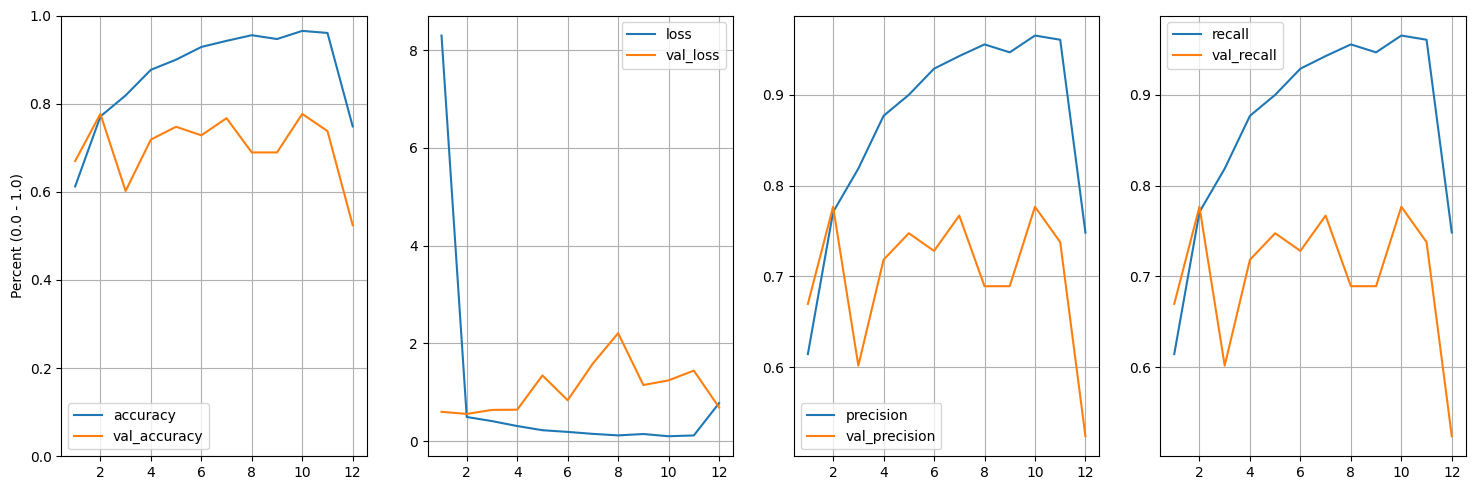


Epoch 12: val_accuracy did not improve from 0.77670
61/61 - 11s - 187ms/step - accuracy: 0.7483 - loss: 0.7798 - precision: 0.7483 - recall: 0.7483 - val_accuracy: 0.5243 - val_loss: 0.6920 - val_precision: 0.5243 - val_recall: 0.5243
Epoch 12: early stopping
Model fit time: 612.3843827630003


In [29]:
mc_callback = ModelCheckpoint('best_model3.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [PlotLearning(), es_callback, mc_callback, tensorboard_callback]

try:
  with tf.device(THE_DEVICE_NAME):
    # fit model, actual training against data, see: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
    history3 = model3.fit(train_it,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_data=test_it,
                          validation_split=VALIDATION_SPLIT,
                          class_weight=None,             #you would be a set of weights per category if you had an unbalanced classification problem
                          verbose=2,                     #0 silent, 1 more, 2 max
                          )

except (Exception, RuntimeError) as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)


end_t=perf_counter()
print(f"Model fit time: {end_t - start_t}")

## Tranfer Learning Model (VGG 16)

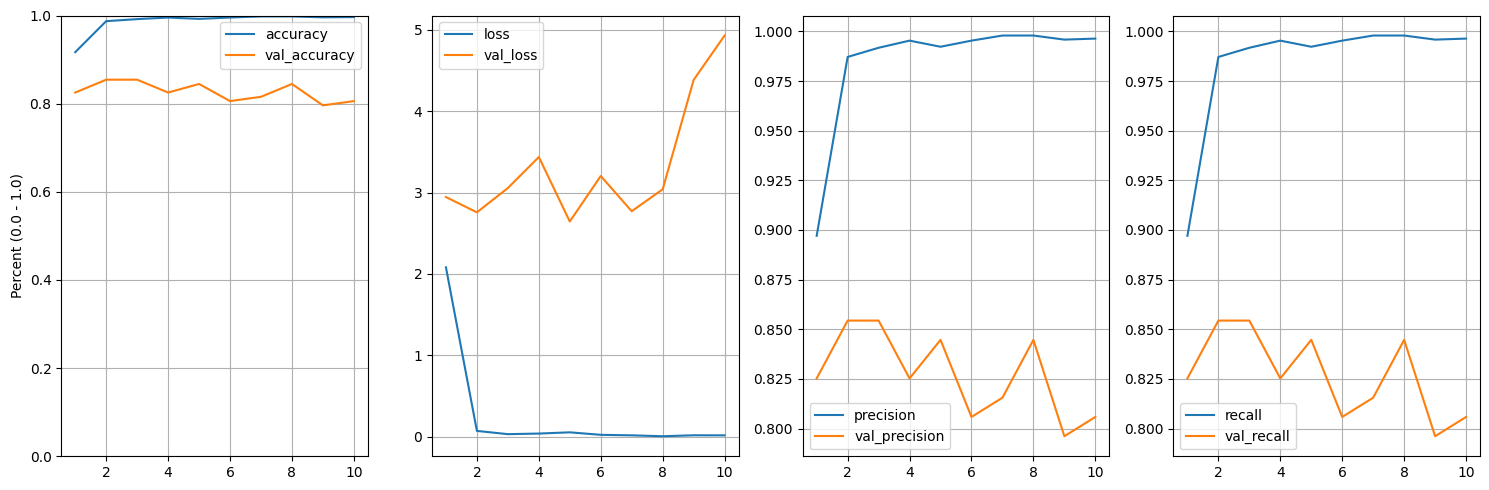


Epoch 10: val_accuracy did not improve from 0.85437
61/61 - 13s - 212ms/step - accuracy: 0.9964 - loss: 0.0158 - precision: 0.9964 - recall: 0.9964 - val_accuracy: 0.8058 - val_loss: 4.9288 - val_precision: 0.8058 - val_recall: 0.8058
Epoch 10: early stopping
Model fit time: 785.037157233


In [30]:
es_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_callback = ModelCheckpoint('best_modelVGG16.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

callbacks_list = [PlotLearning(), es_callback, mc_callback, tensorboard_callback]

try:
  with tf.device(THE_DEVICE_NAME):
    # fit model, actual training against data, see: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
    historyTransfer = modelTransfer.fit(train_it,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=callbacks_list,
                                        validation_data=test_it,
                                        validation_split=VALIDATION_SPLIT,
                                        class_weight=None,             #you would be a set of weights per category if you had an unbalanced classification problem
                                        verbose=2,                     #0 silent, 1 more, 2 max
                                       )

except (Exception, RuntimeError) as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)


end_t=perf_counter()
print(f"Model fit time: {end_t - start_t}")

In [39]:
# plot diagnostic learning curves
def summarize_diagnostics_seaborn(history, title):
  # Create pandas DataFrame
  df_history = pd.DataFrame(history.history)
  #print(df_history)

  #turn values into real percents
  df_history['Training_Accuracy'] = df_history["accuracy"] * 100.0
  df_history['Validation_Accuracy'] = df_history["val_accuracy"] * 100.0

  #color palette
  palette = ['r','b','g']

  # Plot using Seaborn
  sns.set_style("darkgrid", {"axes.facecolor": ".9"})
  sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
  fig = plt.figure(figsize=[7,5])
  ax = plt.subplot(111)
  my_plot = sns.lineplot(data=df_history[["Training_Accuracy","Validation_Accuracy"]],
                         markers=True, dashes=False,palette=palette)

  my_plot.set_xlabel('Epochs')
  my_plot.set_ylim(0,100)
  my_plot.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
  my_plot.set_ylabel('Accuracy')

  plt.title('Training and Validation Loss \n' + title)
  ttl = ax.title
  ttl.set_weight('bold')


  plt.show()

In [40]:
def show_performance_curve(training_result, metric, metric_label):

	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
	intersection_idx = np.argwhere(np.isclose(train_perf,
                                            	validation_perf, atol=1e-2)).flatten()[0]
	intersection_value = train_perf[intersection_idx]

	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')

	plt.annotate(f'Optimal Value: {intersection_value:.4f}',
         	xy=(intersection_idx, intersection_value),
         	xycoords='data',
         	fontsize=10,
         	color='green')

	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')
	plt.title(metric)
	plt.show()

## Demonstrate Model Performance

  1 Layer Model
4/4 - 1s - 175ms/step - accuracy: 0.6893 - loss: 970.3878 - precision: 0.6893 - recall: 0.6893
  Loss >  970.39
Accuracy>  68.93%





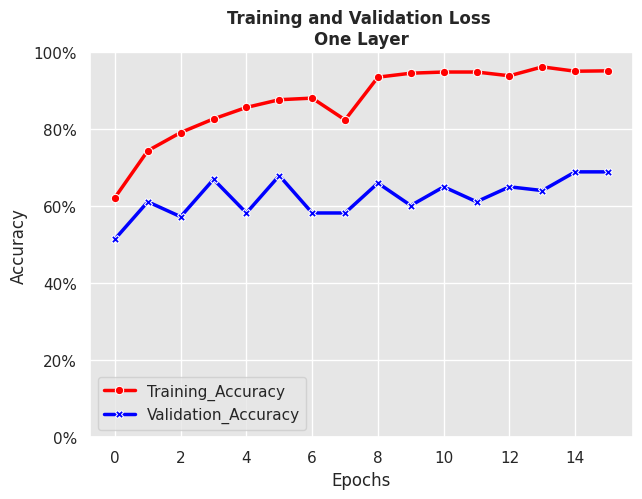

In [41]:
# model 1
try:
    print(f'  {start}1 Layer Model{end}')
    #loss, accuracy, precision, recall = model1.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    loss, accuracy, precision, recall = model1.evaluate(test_it, verbose=2)

    print(f'  {start}Loss{end} > {loss: .2f}')
    print(f'{start}Accuracy{end}> {accuracy: .2%}')
    print("\n\n")
    summarize_diagnostics_seaborn(history1, "One Layer")
    #show_performance_curve(history1, 'accuracy', 'accuracy')
    #show_performance_curve(history1, 'precision', 'precision')
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)



  2 Layer Model
  Loss >  46.29
Accuracy>  66.02%





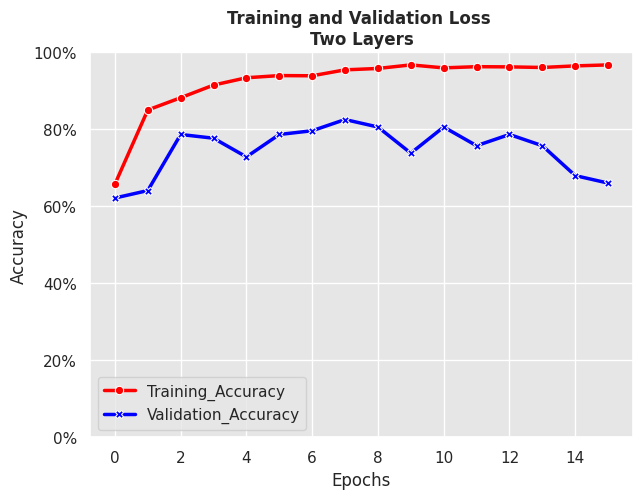

In [42]:
#model 2
print("\n")
print(f'  {start}2 Layer Model{end}')
loss, accuracy, precision, recall = model2.evaluate(test_it, steps=len(test_it), verbose=0)
print(f'  {start}Loss{end} > {loss: .2f}')
print(f'{start}Accuracy{end}> {accuracy: .2%}')
print("\n\n")
summarize_diagnostics_seaborn(history2, "Two Layers")
#show_performance_curve(history2, 'accuracy', 'accuracy')
#show_performance_curve(history2, 'precision', 'precision')




  3 Layer Model
4/4 - 1s - 161ms/step - accuracy: 0.5243 - loss: 0.6920 - precision: 0.5243 - recall: 0.5243
  Loss >  0.69
Accuracy>  52.43%





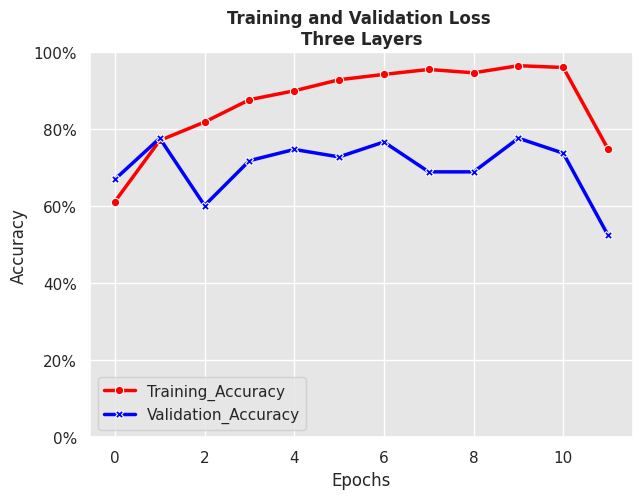

In [43]:
# model 3
print("\n")
print(f'  {start}3 Layer Model{end}')
loss, accuracy, precision, recall = model3.evaluate(test_it, steps=len(test_it), verbose=2)
print(f'  {start}Loss{end} > {loss: .2f}')
print(f'{start}Accuracy{end}> {accuracy: .2%}')
print("\n\n")
summarize_diagnostics_seaborn(history3, "Three Layers")
#show_performance_curve(history3, 'accuracy', 'accuracy')
#show_performance_curve(history3, 'precision', 'precision')

VGG16 Model


4/4 - 1s - 192ms/step - accuracy: 0.8058 - loss: 4.9288 - precision: 0.8058 - recall: 0.8058
  Loss >  4.93
Accuracy>  80.58%





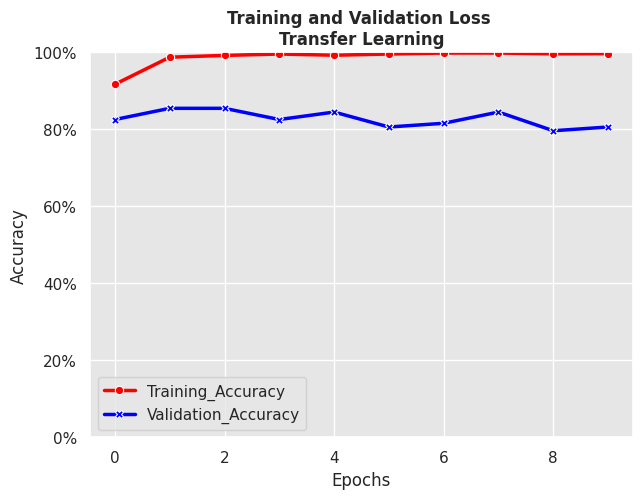

In [44]:
#model transfer learning
try:
  print(f'{start}VGG16 Model{end}')
  print("\n")
  loss, accuracy, precision, recall = modelTransfer.evaluate(test_it, steps=len(test_it), verbose=2)
  print(f'  {start}Loss{end} > {loss: .2f}')
  print(f'{start}Accuracy{end}> {accuracy: .2%}')
  print("\n\n")
  summarize_diagnostics_seaborn(historyTransfer, "Transfer Learning")
  #show_performance_curve(historyTransfer, 'accuracy', 'accuracy')
  #show_performance_curve(historyTransfer, 'precision', 'precision')
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)


## Inference

In [45]:
print(f"{start}Loading saved model definitions and weights.{end}")
try:
    best_model1 = load_model('./best_model1.keras')
    best_model2 = load_model('./best_model2.keras')
    best_model3 = load_model('./best_model3.keras')
    best_modelVGG16 = load_model('./best_modelVGG16.keras')
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)

Loading saved model definitions and weights.


Load a sample image.
Obtain an inference from each model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


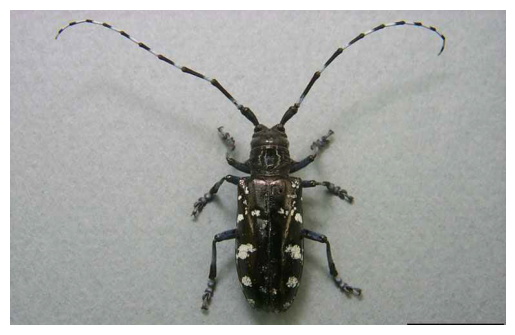

In [46]:
# load and prepare the image
def load_image(img):

  #resize the image
  newsize = (IMG_HEIGHT, IMG_WIDTH)
  img1 = img.resize(newsize)

  # convert to array
  img2 = img_to_array(img1)

  # reshape into a single sample with 3 channels
  img = img2.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)

  # ensure datatype
  img = img.astype('float32')

  # scale image, we did this to the training data, you must scale the inference input!!!
  img = img / 255.0
  return img

# load an image and predict the class
def run_example(inc_url, inc_model):

  # load the image
  img = load_image(inc_url)

  # predict the class
  result = inc_model.predict(img)
  return result

print("Load a sample image.")
filename="./folderOnColab/ENTOMOLOGY/validation/alb/001.jpg"
#filename="./folderOnColab/ENTOMOLOGY/validation/slf/001.jpg"
img = load_img(filename, target_size=(IMG_HEIGHT, IMG_WIDTH))

print("Obtain an inference from each model.")
try:
    results1 = run_example(img, best_model1)
    results2 = run_example(img, best_model2)
    results3 = run_example(img, best_model3)
    resultsVGG16 = run_example(img, best_modelVGG16)
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)

the_logo = Image.open(filename)

#turn the image into a displayed graphic
plt.figure()
plt.axis('off')
plt.imshow(the_logo)
plt.show()

In [47]:
print(f"{start}Evaluate the Models{end}")
print('\n')

#model 1
try:
  class_names = categories
  predicted_class_index = np.argmax(results1)
  predicted_class = class_names[predicted_class_index]
  print(f'  {start}1 Layer Model{end}')
  print(f'{start}{predicted_class}{end}> {results1}')
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
print('\n')

#model 2
try:
  class_names = categories
  predicted_class_index = np.argmax(results2)
  predicted_class = class_names[predicted_class_index]
  print("\n")
  print(f'  {start}2 Layer Model{end}')
  #print(f'{start}{predicted_class}{end}> {predicted_class_index: .2%}')
  print(f'{start}{predicted_class}{end}> {results2}')
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
print('\n')

#model 3
try:
  class_names = categories
  predicted_class_index = np.argmax(results3)
  predicted_class = class_names[predicted_class_index]
  print("\n")
  print(f'  {start}3 Layer Model{end}')
  #print(f'{start}{predicted_class}{end}> {predicted_class_index: .2%}')
  print(f'{start}{predicted_class}{end}> {results3}')
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
print('\n')

#VGG16
try:
  class_names = categories
  predicted_class_index = np.argmax(resultsVGG16)
  predicted_class = class_names[predicted_class_index]
  print("\n")
  print(f'  {start}VGG16 Model{end}')
  #print(f'{start}{predicted_class}{end}> {predicted_class_index: .2%}')
  print(f'{start}{predicted_class}{end}> {resultsVGG16}')
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
print('\n')

Evaluate the Models


  1 Layer Model
ASIAN_LONGHORN_BEETLE> [[9.9999976e-01 2.2644745e-07]]




  2 Layer Model
ASIAN_LONGHORN_BEETLE> [[0.5301024 0.4698976]]




  3 Layer Model
SPOTTED_LANTERN_FLY> [[0.48692948 0.5130705 ]]




  VGG16 Model
ASIAN_LONGHORN_BEETLE> [[0.888082   0.11191798]]




In [48]:
# Interpret the predictions
try:
  print(f"{start}Model VGG16 Analysis{end}")
  class_names = categories
  predicted_class_index = np.argmax(resultsVGG16)
  predicted_class = class_names[predicted_class_index]

  print(f"{start}Predicted class:{end}", predicted_class)
  print(f"{start}Predicted class index:{end}", predicted_class_index)
  print(f"{start}Predicted class probability:{end}, {resultsVGG16[0][predicted_class_index]:.1%}")

except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)

Model VGG16 Analysis
Predicted class: ASIAN_LONGHORN_BEETLE
Predicted class index: 0
Predicted class probability:, 88.8%


## Inference through Validation Dataset

In [49]:
#get a list of all validation files
import os
import random

alb_files=os.listdir("./folderOnColab/ENTOMOLOGY/validation/alb")
slf_files=os.listdir("./folderOnColab/ENTOMOLOGY/validation/slf")

#divisor, cut down just how many images we show
divisor=5

#determine how many you have
alb_num=len(alb_files)
slf_num=len(slf_files)
print(f"There are {alb_num} files in the Asian Longhorn Bettle domain.")
print(f"There are {slf_num} files in the Spotted Lantern Fly domain.")

minimal_count = int(min([alb_num, slf_num])/divisor)  #let's not make too many images
print(f"There are {minimal_count} total files you can work with in either folder.")
print(f"Creating random list of files to choose from.")

#build an array to hold the randomly created names
y_true_filenames=[]
y_true = []
for idx in range(0,minimal_count):
  category_idx=int(random.randrange(0, 2))
  file_idx=int(random.randrange(0,minimal_count))
  if category_idx==0:
    category="alb"
  else:
    category="slf"
  if file_idx < 10:
    filename="00"
  else:
    filename="0"
  the_filename=f"./folderOnColab/ENTOMOLOGY/validation/{category}/{filename}{file_idx}.jpg"
  y_true_filenames.append(the_filename)
  y_true.append(class_names[category_idx])


There are 49 files in the Asian Longhorn Bettle domain.
There are 54 files in the Spotted Lantern Fly domain.
There are 9 total files you can work with in either folder.
Creating random list of files to choose from.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
TRUTH == SPOTTED_LANTERN_FLY
Iteration[0] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 19.1% 
Iteration[0] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 55.7% 
Iteration[0] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.3% 
Iteration[0] = VGG16 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 80.9% 


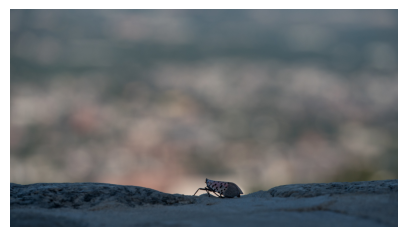

#######################################################################################




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
TRUTH == SPOTTED_LANTERN_FLY
Iteration[1] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 75.2% 
Iteration[1] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 55.7% 
Iteration[1] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.4% 
Iteration[1] = VGG16 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 75.2% 


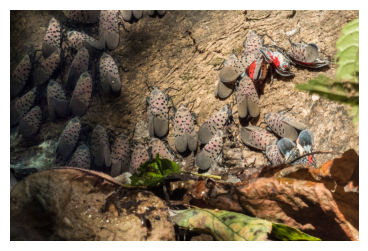

#######################################################################################




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
TRUTH == SPOTTED_LANTERN_FLY
Iteration[2] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 49.9% 
Iteration[2] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 57.6% 
Iteration[2] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.4% 
Iteration[2] = VGG16 Predicted class:: SPOTTED_LANTERN_FLY[1], 50.1% 


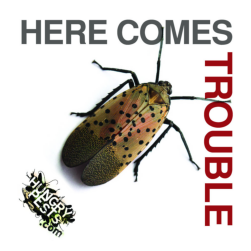

#######################################################################################




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
TRUTH == ASIAN_LONGHORN_BEETLE
Iteration[3] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 88.8% 
Iteration[3] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 53.0% 
Iteration[3] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.3% 
Iteration[3] = VGG16 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 88.8% 


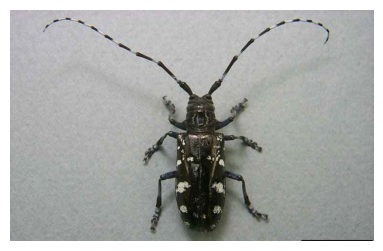

#######################################################################################




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
TRUTH == SPOTTED_LANTERN_FLY
Iteration[4] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 22.1% 
Iteration[4] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.5% 
Iteration[4] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.3% 
Iteration[4] = VGG16 Predicted class:: SPOTTED_LANTERN_FLY[1], 77.9% 


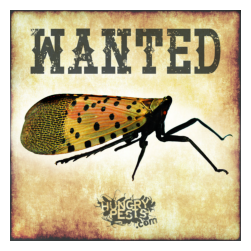

#######################################################################################




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
TRUTH == SPOTTED_LANTERN_FLY
Iteration[5] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 22.1% 
Iteration[5] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.5% 
Iteration[5] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.3% 
Iteration[5] = VGG16 Predicted class:: SPOTTED_LANTERN_FLY[1], 77.9% 


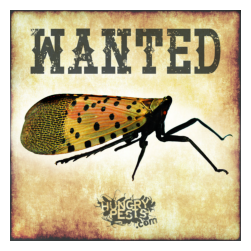

#######################################################################################




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
TRUTH == SPOTTED_LANTERN_FLY
Iteration[6] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 11.9% 
Iteration[6] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 93.9% 
Iteration[6] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.5% 
Iteration[6] = VGG16 Predicted class:: SPOTTED_LANTERN_FLY[1], 88.1% 


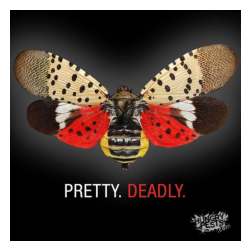

#######################################################################################




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
TRUTH == ASIAN_LONGHORN_BEETLE
Iteration[7] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 88.8% 
Iteration[7] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 53.0% 
Iteration[7] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.3% 
Iteration[7] = VGG16 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 88.8% 


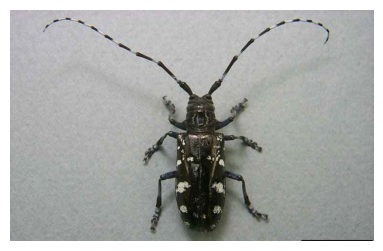

#######################################################################################




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
TRUTH == SPOTTED_LANTERN_FLY
Iteration[8] = Model#1 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 75.2% 
Iteration[8] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 55.7% 
Iteration[8] = Model#1 Predicted class:: SPOTTED_LANTERN_FLY[1], 51.4% 
Iteration[8] = VGG16 Predicted class:: ASIAN_LONGHORN_BEETLE[0], 75.2% 


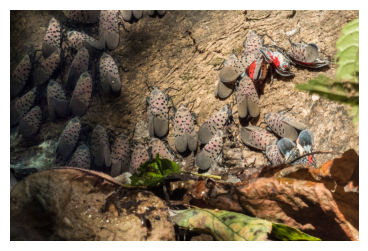

#######################################################################################






In [50]:
#create arrays to hold the results.
y_pred_Model1 = []
y_pred_Model2 = []
y_pred_Model3 = []
y_pred_VGG16 = []


class_names = categories
#now iterate through each image, mark the identification, gather the results and produce a confusion matrix to show true quality of the image model
for idx, target_filename, in enumerate(y_true_filenames):
    img = load_img(target_filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    try:
        results1=run_example(img, best_model1)
    except Exception as e:
        print(f"Model 1 had issues with inference, see: {str(repr(e))}")

    try:
        results2=run_example(img, best_model2)
    except Exception as e:
        print(f"Model 2 had issues with inference, see: {str(repr(e))}")

    try:
        results3=run_example(img, best_model3)
    except Exception as e:
        print(f"Model 3 had issues with inference, see: {str(repr(e))}")

    try:
        resultsVGG16 = run_example(img, best_modelVGG16)
    except Exception as e:
        print(f"Model VGG16 had issues with inference, see: {str(repr(e))}")


    print(f"TRUTH == {y_true[idx]}")

    try:
        predicted_class_index = np.argmax(results1)
        predicted_class = class_names[predicted_class_index]
        y_pred_Model1.append( predicted_class )
        print(f"Iteration[{idx}] = Model#1 {start}Predicted class:{end}: {predicted_class}[{predicted_class_index}], {resultsVGG16[0][predicted_class_index]:.1%} ")
    except Exception as e:
        print(f"Model 1 had issues, see: {str(repr(e))}")


    try:
        predicted_class_index = np.argmax(results2)
        predicted_class = class_names[predicted_class_index]
        y_pred_Model2.append( predicted_class )
        print(f"Iteration[{idx}] = Model#1 {start}Predicted class:{end}: {predicted_class}[{predicted_class_index}], {results2[0][predicted_class_index]:.1%} ")
    except Exception as e:
        print(f"Model 2 had issues, see: {str(repr(e))}")

    try:
        predicted_class_index = np.argmax(results3)
        predicted_class = class_names[predicted_class_index]
        y_pred_Model3.append( predicted_class )
        print(f"Iteration[{idx}] = Model#1 {start}Predicted class:{end}: {predicted_class}[{predicted_class_index}], {results3[0][predicted_class_index]:.1%} ")
    except Exception as e:
        print(f"Model 3 had issues, see: {str(repr(e))}")

    try:
        predicted_class_index = np.argmax(resultsVGG16)
        predicted_class = class_names[predicted_class_index]
        y_pred_VGG16.append( predicted_class )
        print(f"Iteration[{idx}] = VGG16 {start}Predicted class:{end}: {predicted_class}[{predicted_class_index}], {resultsVGG16[0][predicted_class_index]:.1%} ")
    except Exception as e:
        print(f"Model VGG16 had issues, see: {str(repr(e))}")

    the_logo = Image.open(target_filename)
    #turn the image into a displayed graphic
    plt.figure(figsize=(5,3))
    plt.axis('off')
    plt.imshow(the_logo)
    plt.show()
    print("#######################################################################################")
    print("\n\n\n")


## Confusion Matrix

The confusion matrix is a 2 dimensional array comparing predicted category labels to the true label. For binary classification, these are the True Positive, True Negative, False Positive and False Negative categories.

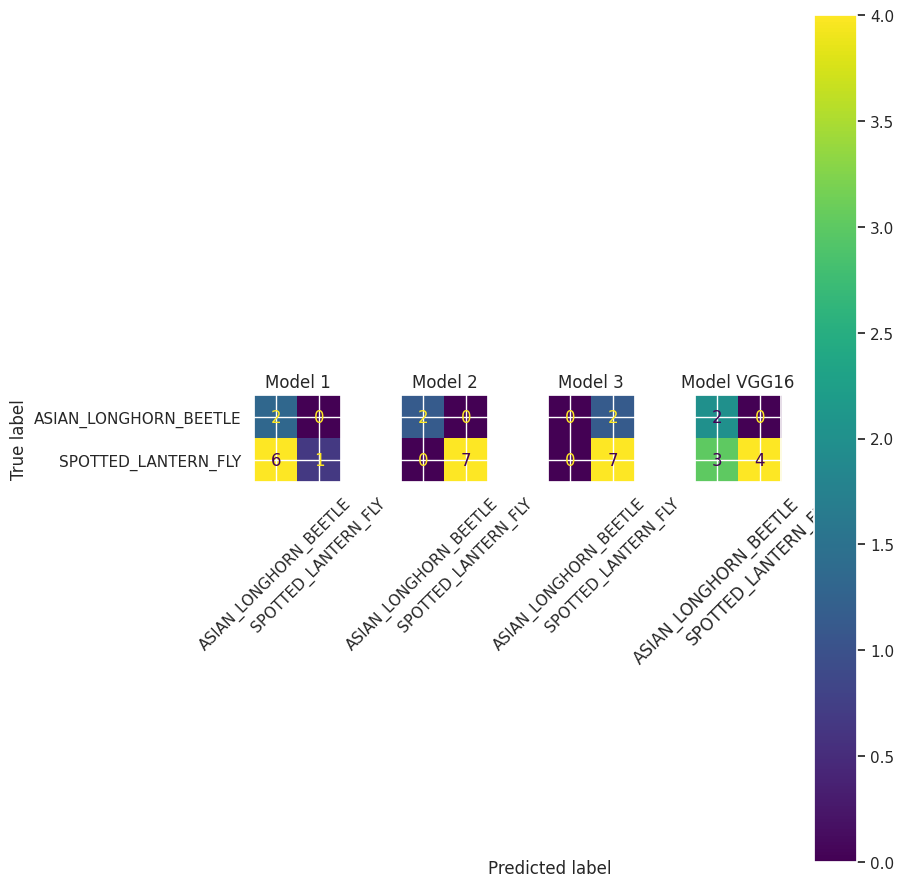

In [51]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#build the confusion matrices
cms={}
try:
    cms['Model 1']=confusion_matrix(y_true, y_pred_Model1, labels=class_names)
except Exception as e:
    print(f"Model 1 had issues with inference, see: {str(repr(e))}")

try:
    cms['Model 2']=confusion_matrix(y_true, y_pred_Model2, labels=class_names)
except Exception as e:
    print(f"Model 2 had issues with inference, see: {str(repr(e))}")

try:
    cms['Model 3']=confusion_matrix(y_true, y_pred_Model3, labels=class_names)
except Exception as e:
    print(f"Model 3 had issues with inference, see: {str(repr(e))}")

try:
    cms['Model VGG16']=confusion_matrix(y_true, y_pred_VGG16, labels=class_names)
except Exception as e:
    print(f"Model 1 had issues with inference, see: {str(repr(e))}")

elements=len(cms)

# create the plot
f, axes = plt.subplots(1, elements, figsize=(8.5, 11.0), sharey='row')
# Setting default size of the plot
plt.rcParams['figure.figsize'] = (8.5, 11.0)
# Setting default fontsize used in the plot
plt.rcParams['font.size'] = 12

# Setting fontsize for xticks and yticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for idx, key in enumerate(cms.keys()):
    disp = ConfusionMatrixDisplay(cms[key],
                                  display_labels=class_names)
    disp.plot(ax=axes[idx], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if idx!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.70, hspace=0.5)

# Giving name to the plot
#plt.title('Confusion Matrix for Invasive Species', fontsize=24)

f.colorbar(disp.im_, ax=axes)
plt.show()
# Saving plot
#plt.savefig('confusion_matrix', transparent=True, dpi=500)


## Classification Report

In [52]:
#Showing the main classification metrics
print(f"{start}Model 1 Classification Report{end}")
print(classification_report(y_true, y_pred_Model1))

Model 1 Classification Report
                       precision    recall  f1-score   support

ASIAN_LONGHORN_BEETLE       0.25      1.00      0.40         2
  SPOTTED_LANTERN_FLY       1.00      0.14      0.25         7

             accuracy                           0.33         9
            macro avg       0.62      0.57      0.33         9
         weighted avg       0.83      0.33      0.28         9



In [53]:
#Showing the main classification metrics
print(f"{start}Model 2 Classification Report{end}")
print(classification_report(y_true, y_pred_Model2))

Model 2 Classification Report
                       precision    recall  f1-score   support

ASIAN_LONGHORN_BEETLE       1.00      1.00      1.00         2
  SPOTTED_LANTERN_FLY       1.00      1.00      1.00         7

             accuracy                           1.00         9
            macro avg       1.00      1.00      1.00         9
         weighted avg       1.00      1.00      1.00         9



In [54]:
#Showing the main classification metrics
print(f"{start}Model 3 Classification Report{end}")
print(classification_report(y_true, y_pred_Model3))

Model 3 Classification Report
                       precision    recall  f1-score   support

ASIAN_LONGHORN_BEETLE       0.00      0.00      0.00         2
  SPOTTED_LANTERN_FLY       0.78      1.00      0.88         7

             accuracy                           0.78         9
            macro avg       0.39      0.50      0.44         9
         weighted avg       0.60      0.78      0.68         9



In [55]:
#Showing the main classification metrics
print(f"{start}Model VGG16 Classification Report{end}")
print(classification_report(y_true, y_pred_VGG16))

Model VGG16 Classification Report
                       precision    recall  f1-score   support

ASIAN_LONGHORN_BEETLE       0.40      1.00      0.57         2
  SPOTTED_LANTERN_FLY       1.00      0.57      0.73         7

             accuracy                           0.67         9
            macro avg       0.70      0.79      0.65         9
         weighted avg       0.87      0.67      0.69         9



## Show the Model Layers

In [ ]:
try:
    #best_model1, best_model2, best_model3, best_modelTransfer
    target_model='best_model1'
    tf.keras.utils.plot_model(
        load_model(target_model+'.keras'),
        to_file='./'+target_model+'.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=True,
        dpi=96,
    )
except Exception as e:
    print(f"{start}ERROR (Exception encountered):{end} ")
    string = wrapper.fill(text=str(e))
    print(string)



try:
  img=Image.open('./'+target_model+'.png')
  img.show()
except Exception as e:
    print(f"{start}ERROR (Exception encountered): Unable to display image.{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
